<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer
import requests
import squarify

from bs4 import BeautifulSoup

nlp = spacy.load("en_core_web_lg")

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
def soupify(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text().replace("\\n", ' ').strip('b"').strip("b'").replace('\\xe2\\x80\\x99', "'")

In [3]:
filename = os.path.join("data", "job_listings.csv")

df = pd.read_csv(filename, encoding='utf-8')
df = df[df["title"].str.lower().str.contains("data scientist")]
df['soup'] = df['description'].apply(soupify)

df.head()

,Unnamed: 0,description,title,soup
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you wi..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA \xe2\x80\x93 multiple locations ...


In [4]:
for item in df.head()['soup'].to_list():
    print(item)
    print("")

Job Requirements: Conceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role) Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R Ability to communicate Model findings to both Technical and Non-Technical stake holders Hands on experience in SQL/Hive or similar programming language Must show past work via GitHub, Kaggle or any other published article Master's degree in Statistics/Mathematics/Computer Science or any other quant specific field. Apply Now

Job Description  As a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help our clients navigate their healthcare jou

## 2) Use Spacy to tokenize the listings 

In [5]:
tokenizer = Tokenizer(nlp.vocab)
STOP_WORDS = nlp.Defaults.stop_words.union(
    ['I','i', '1', '', ' ','-', "it's", 'it.', 'the', "i'm", "i've", 'this']
)

# Tokenizer Pipe
tokens = []
for doc in tokenizer.pipe(df['soup'], batch_size=500):
    doc_tokens = []
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
    doc_tokens.pop(0)
#     doc_tokens.remove('check-in')
    tokens.append(doc_tokens)
df['tokens'] = tokens

df.head()

,Unnamed: 0,description,title,soup,tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...,"[requirements:, conceptual, understanding, mac..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you wi...","[description, data, scientist, 1,, help, build..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"[scientist, working, consulting, business., re..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener...","[$6,756, monthcontractunder, general, supervis..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA \xe2\x80\x93 multiple locations ...,"[usa, \xe2\x80\x93, multiple, locations, 2+, y..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(
    ['li', 'div', 'br', 'ul', 'xe2', 'x80', 'x99s',
    'data']
)

text = df['soup'].to_list()

# create the transformer
vect = CountVectorizer(stop_words=stop_words, max_features=1000)

# build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)

In [7]:
word_counts = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
word_counts.head()

,000,10,100,12,2019,40,abilities,ability,able,academic,...,xa2,xa6,xae,xb7,xbb,xc2,xef,year,years,york
0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,2,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## 4) Visualize the most common word counts

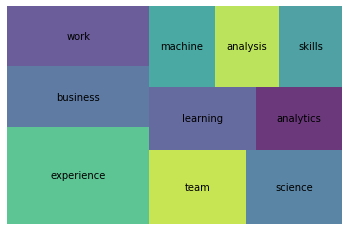

In [8]:
word_sum = word_counts.sum().sort_values(ascending=False)
word_sum.rename("String")
word_sum = word_sum.to_frame().reset_index().rename(columns={"index":"word", 0: "count"}).head(10)

squarify.plot(sizes=word_sum['count'], label=word_sum['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [9]:
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=1000)

dtm = tfidf.fit_transform(text)

feature_matrix = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

feature_matrix.head()

,000,10,100,12,2019,40,abilities,ability,able,academic,...,xa2,xa6,xae,xb7,xbb,xc2,xef,year,years,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158715,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.206481,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029595,0.0,0.0,...,0.0,0.150216,0.0,0.0,0.0,0.000000,0.0,0.056525,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082106,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.098153,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.149658,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [10]:
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(feature_matrix)

custom_job_description = [ """
Entry level position in data science, must be team driven and have experience in NumPy, SciPy, Pandas, and Matplotlib.
"""]

new = tfidf.transform(custom_job_description)
nn.kneighbors(new.todense())

(array([[1.21871865, 1.28585664, 1.30111408, 1.30111408, 1.30342073]]),
 array([[  0, 219, 301, 198, 286]], dtype=int64))

In [11]:
text[219]

"Functional Description: Designs, develops and programs methods, processes, and systems to consolidate and analyze unstructured, diverse \\xe2\\x80\\x9cbig data\\xe2\\x80\\x9d sources to generate actionable insights and solutions for client services and product enhancement. Interacts with product and service teams to identify questions and issues for data analysis and experiments. Develops and codes software programs, algorithms and automated processes to cleanse, integrate and evaluate large datasets from multiple disparate sources. Identifies meaningful insights from large data and metadata sources; interprets and communicates insights and findings from analysis and experiments to product, service, and business managers. About Dexcom: Founded in 1999, Dexcom, Inc. provides continuous glucose monitoring technology to help patients and their clinicians better manage diabetes. Since our inception, we have focused on better outcomes for patients, caregivers, and clinicians by delivering 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 